In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # RNN developing
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

import matplotlib.pyplot as plt # drawing, visualization
import seaborn as sns # drawing, visualization

import datetime
from datetime import datetime as dt

from kaggle.competitions import twosigmanews

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


In [95]:
print(tf.__version__)

1.13.1


In [96]:
# Retreive the environment of the competition
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Data loaded!')

Exception: You can only make one environment for this competition.

In [97]:
# Retrieve all training data
(market_train_df, news_train_df) = env.get_training_data()
print("Fetching training data finished... ")
print('Data obtained!')

Fetching training data finished... 
Data obtained!


In [98]:
#### Market data analysis
# Types of the columns
#print(market_train_df.dtypes)
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [99]:
# News data analysis
# Types of the columns
#print(news_train_df.dtypes)
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'EMRG', 'RTRS', 'CRU', 'ENR', 'ASIA', 'LEN', ...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', 'PTR.N', '0857.F', '0857.DE'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'CO', 'HT', 'LIF', 'LATAM', 'RTRS', 'MX', 'AS...","{'ESN', 'RNP', 'G', 'E', 'U', 'PCO', 'PCU', 'M...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'BG', 'TH', 'RET', 'RTRS', 'ID', 'RO', 'ENR',...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.N', 'WMT.DE'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'LEI', 'INS', 'RTRS', 'USC', 'WWW', 'FUND', '...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'LEI', 'INS', 'RTRS', 'USC', 'WWW', 'FUND', '...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


In [100]:
# Minor changes on dates so they match the day
market_train_df['time'] = market_train_df['time'].dt.tz_convert(None).dt.normalize()
news_train_df['time'] = news_train_df['time'].dt.tz_convert(None).dt.normalize()

In [101]:
# Lets remove some market columns
cols_to_keep_market = ["time", "assetName", "returnsOpenNextMktres10"]
market_train_df = market_train_df[cols_to_keep_market]
market_train_df.head()

,time,assetName,returnsOpenNextMktres10
0,2007-02-01,Agilent Technologies Inc,0.034672
1,2007-02-01,AirTran Holdings Inc,0.027803
2,2007-02-01,Advance Auto Parts Inc,0.024433
3,2007-02-01,Apple Inc,-0.007425
4,2007-02-01,ABB Ltd,-0.017994


In [102]:
# Lets summarize the news
news_train_df["sent_rel"] = news_train_df["urgency"] * news_train_df["relevance"] * (news_train_df["sentimentPositive"]-news_train_df["sentimentNegative"]) 
cols_to_keep_news = ["time", "assetName", "sent_rel"]
news_train_df = news_train_df[cols_to_keep_news]
# Convert news of same day and asset to one row only
#d = {'sent_rel': 'mean', 'name': 'first', 'amount': 'sum'}
d_aggs = {'sent_rel' : 'mean'}
news_train_df=news_train_df[["time", "assetName"]+list(d_aggs.keys())].groupby(['time', 'assetName'], as_index=False).aggregate(d_aggs)
news_train_df.head()

,time,assetName,sent_rel
0,2007-01-01,BHP Billiton Ltd,0.146039
1,2007-01-01,Citigroup Inc,0.223644
2,2007-01-01,Constellation Brands Inc,0.034320
3,2007-01-01,Cyren Ltd,-0.502698
4,2007-01-01,Fomento Economico Mexicano SAB de CV,0.614812


In [103]:
# Merge market and news data
df_final = market_train_df.merge(news_train_df, how = 'left', on = ['time', 'assetName'])
# Replace NaNs
df_final.fillna({'sent_rel':df_final["sent_rel"].mean()}, inplace=True)
print(len(df_final))
df_final.head()

4072956


,time,assetName,returnsOpenNextMktres10,sent_rel
0,2007-02-01,Agilent Technologies Inc,0.034672,0.723783
1,2007-02-01,AirTran Holdings Inc,0.027803,0.801957
2,2007-02-01,Advance Auto Parts Inc,0.024433,0.400396
3,2007-02-01,Apple Inc,-0.007425,0.400396
4,2007-02-01,ABB Ltd,-0.017994,0.141685


### Some companies data

#### Santander

['Banco Santander Brasil SA', 'Banco Santander SA', 'Banco Santander-Chile', 'Santander Bancorp', 'Santander Consumer USA Holdings Inc', 'Santander Holdings USA Inc']


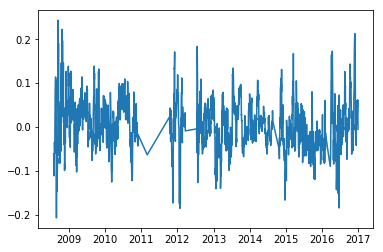

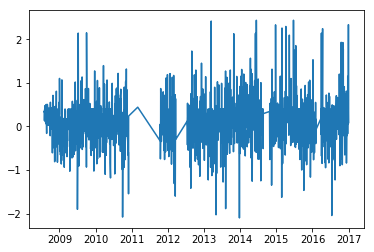

In [113]:
santander_names = [n for n in np.unique(df_final.assetName) if "Santander" in n]
print(santander_names)
santander_df = df_final[df_final.assetName == 'Banco Santander SA']
plt.plot(santander_df.time, santander_df["returnsOpenNextMktres10"])
plt.show()
plt.plot(santander_df.time, santander_df["sent_rel"])
plt.show()

#### Facebook

['Facebook Inc']


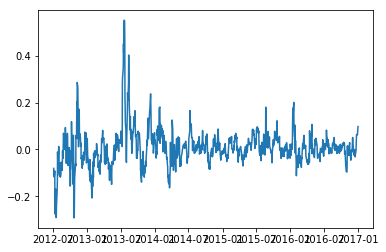

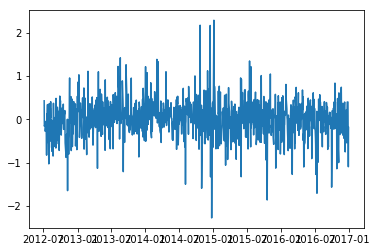

In [114]:
facebook_names = [n for n in np.unique(df_final.assetName) if "Face" in n]
print(facebook_names)
facebook_df = df_final[df_final.assetName == 'Facebook Inc']
plt.plot(facebook_df.time, facebook_df["returnsOpenNextMktres10"])
plt.show()
plt.plot(facebook_df.time, facebook_df["sent_rel"])
plt.show()

#### Apple

['Apple Hospitality REIT Inc', 'Apple Inc', "Applebee's International Inc"]


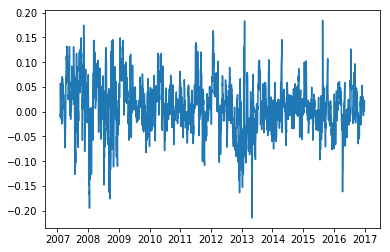

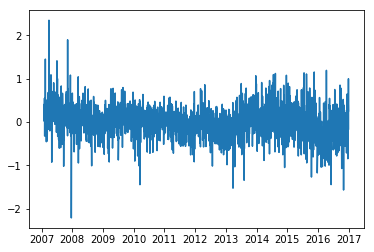

In [115]:
apple_names = [n for n in np.unique(df_final.assetName) if "Apple" in n]
print(apple_names)
apple_df = df_final[df_final.assetName == 'Apple Inc']
plt.plot(apple_df.time, apple_df["returnsOpenNextMktres10"])
plt.show()
plt.plot(apple_df.time, apple_df["sent_rel"])
plt.show()

#### Oracle

['Oracle America Inc', 'Oracle Corp', 'Oracle OTC Subsidiary LLC', 'Oracle Taleo LLC']


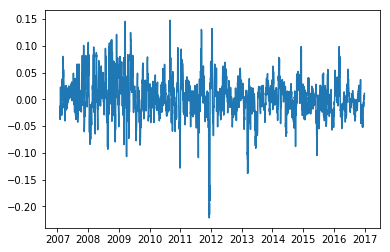

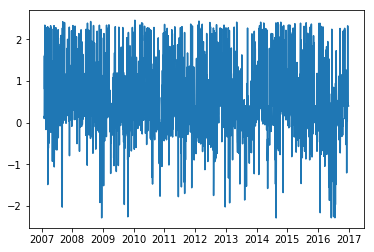

In [116]:
oracle_names = [n for n in np.unique(df_final.assetName) if "Oracle" in n]
print(oracle_names)
oracle_df = df_final[df_final.assetName == 'Oracle Corp']
plt.plot(oracle_df.time, oracle_df["returnsOpenNextMktres10"])
plt.show()
plt.plot(oracle_df.time, oracle_df["sent_rel"])
plt.show()

## Machine Learning

In [ ]:
features = ["returnsOpenNextMktres10", "sent_rel"]
target = "returnsOpenNextMktres10"

## RNN

### Define the model

In [ ]:
# DEFINE THE MODEL
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(16, unroll=True, return_sequences=True))
model.add(tf.keras.layers.LSTM(16, unroll=True))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Select the data and preprocessing

In [ ]:
# SELECT COMPANY DATA TO TRAIN WITH
aux = oracle_df.copy()
# SCALE THE VARIABLES TO HAVE MEAN 0 AND STD DEV 1
# OTHERWISE IT TAKES PLENTY OF TIME TO TRAIN AND IT STARTS WITH THE VALUES CLOSER TO 0
scaler_features = preprocessing.StandardScaler().fit(aux[features])
scaler_target = preprocessing.StandardScaler().fit(aux[target].values.reshape(-1,1))
aux[features] = scaler_features.transform(aux[features])
plt.plot(aux.time, aux[features[0]])
plt.show()
plt.plot(aux.time, aux[features[1]])
plt.show()
# SPLIT INTO TRAIN AND TEST (UP TO 2016 TRAIN, LATER TEST)
train = aux[aux.time < np.datetime64('2016-01-01')]
test = aux[aux.time >= np.datetime64('2016-01-01')]

In [ ]:
# DEFINE THE PERIOD TO LOOK BACK FOR THE RNN
PERIOD = 50

# Preprocess train data
train_X=[]
train_y=[]
train_times=[]
for i in range(PERIOD, train.shape[0]):
    X, y, time = train.iloc[i-PERIOD:i,:][features].values, train.iloc[i,:][target], train.iloc[i,:].time
    train_X.append(X)
    train_y.append(y)
    train_times.append(time)
train_X = np.array(train_X)
train_y = np.array(train_y)
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], PERIOD, len(features)))

# Preprocess test data
test_X=[]
test_y=[]
test_times=[]
for i in range(PERIOD, test.shape[0]):
    X, y, time = test.iloc[i-PERIOD:i,:][features].values, test.iloc[i,:][target], test.iloc[i,:].time
    test_X.append(X)
    test_y.append(y)
    test_times.append(time)
test_X = np.array(test_X)
test_y = np.array(test_y)
# reshape input to be [samples, time steps, features]
test_X = np.reshape(test_X, (test_X.shape[0], PERIOD, len(features)))

### Train and test the model (only one epoch for commit)

In [ ]:
# TRAIN THE MODEL
model.fit(train_X, train_y, batch_size=12, epochs=5, verbose=2, shuffle=False)     

In [ ]:
# MAKE PREDICTIONS
trainPredictions = scaler_target.inverse_transform(model.predict(train_X))
testPredictions = scaler_target.inverse_transform(model.predict(test_X))
# accuracy
test_y2 = [0 if y < 0 else 1 for y in scaler_target.inverse_transform(test_y)]
testPredictions2 = [0 if y < 0 else 1 for y in testPredictions]
# scores
print("MAE:", mean_absolute_error(scaler_target.inverse_transform(test_y), testPredictions))
print("MSE:", mean_squared_error(scaler_target.inverse_transform(test_y), testPredictions))
print("Accuracy: ", accuracy_score(test_y2, testPredictions2))
# plots
plt.plot(train_times, scaler_target.inverse_transform(train_y))
plt.plot(train_times, trainPredictions)
plt.show()
plt.plot(train_times[-20:], scaler_target.inverse_transform(train_y[-20:]))
plt.plot(train_times[-20:], trainPredictions[-20:])
plt.show()
plt.plot(test_times, scaler_target.inverse_transform(test_y))
plt.plot(test_times, testPredictions)
plt.show()
plt.plot(test_times[-20:], scaler_target.inverse_transform(test_y[-20:]))
plt.plot(test_times[-20:], testPredictions[-20:])
plt.show()

### Test on other companies

#### Facebook

In [ ]:
# TEST MODEL ON FACEBOOK
aux = facebook_df.copy()
scaler_features = preprocessing.StandardScaler().fit(aux[features])
scaler_target = preprocessing.StandardScaler().fit(aux[target].values.reshape(-1,1))
aux[features] = scaler_features.transform(aux[features])
test=aux
# Preprocess test data
test_X=[]
test_y=[]
test_times=[]
for i in range(PERIOD, test.shape[0]):
    X, y, time = test.iloc[i-PERIOD:i,:][features].values, test.iloc[i,:][target], test.iloc[i,:].time
    test_X.append(X)
    test_y.append(y)
    test_times.append(time)
test_X = np.array(test_X)
test_y = np.array(test_y)
test_X = np.reshape(test_X, (test_X.shape[0], PERIOD, len(features)))
testPredictions = scaler_target.inverse_transform(model.predict(test_X))
test_y2 = [0 if y < 0 else 1 for y in scaler_target.inverse_transform(test_y)]
testPredictions2 = [0 if y < 0 else 1 for y in testPredictions]
# results
print("MAE:", mean_absolute_error(scaler_target.inverse_transform(test_y), testPredictions))
print("MSE:", mean_squared_error(scaler_target.inverse_transform(test_y), testPredictions))
print("Accuracy: ", accuracy_score(test_y2, testPredictions2))
plt.plot(test_times, scaler_target.inverse_transform(test_y))
plt.plot(test_times, testPredictions)
plt.show()
plt.plot(test_times[-20:], scaler_target.inverse_transform(test_y[-20:]))
plt.plot(test_times[-20:], testPredictions[-20:])
plt.show()

#### Apple

In [ ]:
# TEST MODEL ON APPLE
aux = apple_df.copy()
scaler_features = preprocessing.StandardScaler().fit(aux[features])
scaler_target = preprocessing.StandardScaler().fit(aux[target].values.reshape(-1,1))
aux[features] = scaler_features.transform(aux[features])
test=aux
# Preprocess test data
test_X=[]
test_y=[]
test_times=[]
for i in range(PERIOD, test.shape[0]):
    X, y, time = test.iloc[i-PERIOD:i,:][features].values, test.iloc[i,:][target], test.iloc[i,:].time
    test_X.append(X)
    test_y.append(y)
    test_times.append(time)
test_X = np.array(test_X)
test_y = np.array(test_y)
test_X = np.reshape(test_X, (test_X.shape[0], PERIOD, len(features)))
testPredictions = scaler_target.inverse_transform(model.predict(test_X))
test_y2 = [0 if y < 0 else 1 for y in scaler_target.inverse_transform(test_y)]
testPredictions2 = [0 if y < 0 else 1 for y in testPredictions]
# results
print("MAE:", mean_absolute_error(scaler_target.inverse_transform(test_y), testPredictions))
print("MSE:", mean_squared_error(scaler_target.inverse_transform(test_y), testPredictions))
print("Accuracy: ", accuracy_score(test_y2, testPredictions2))
plt.plot(test_times, scaler_target.inverse_transform(test_y))
plt.plot(test_times, testPredictions)
plt.show()
plt.plot(test_times[-20:], scaler_target.inverse_transform(test_y[-20:]))
plt.plot(test_times[-20:], testPredictions[-20:])
plt.show()

## CNN

In [ ]:
# modelCNN = tf.keras.models.Sequential()
# modelCNN.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
# modelCNN.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
# modelCNN.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
# modelCNN.add(tf.keras.layers.GlobalAveragePooling1D())
# modelCNN.add(tf.keras.layers.Dense(10, activation='sigmoid'))
# modelCNN.add(tf.keras.layers.Dense(1))
# modelCNN.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# ### SCALE THE VARIABLE TO HAVE MEAN 0 AND STD DEV 1
# ### OTHERWISE IT TAKES PLENTY OF TIME TO TRAIN AND IT STARTS WITH THE VALUES CLOSER TO 0
# aux = market_train_df_santander.copy()
# scaler = preprocessing.StandardScaler().fit(aux[target].values.reshape(-1,1))
# aux[target] = scaler.transform(aux[target].values.reshape(-1,1))
# plt.plot(aux.time, aux[target])
# # CONVERT DATES TO HAVE ONLY THE DAY AND NO UTC
# # SPLIT INTO TRAIN AND TEST (UP TO 2016 TRAIN, LATER tEST)
# aux['time'] = aux['time'].dt.tz_convert(None).dt.normalize()
# train = aux[aux.time < np.datetime64('2016-01-01')]
# test = aux[aux.time >= np.datetime64('2016-01-01')]

In [ ]:
# # DEFINE THE PERIOD TO LOOK BACK FOR THE RNN
# PERIOD = 50

# # Preprocess train data
# train_X=[]
# train_y=[]
# train_times=[]
# for i in range(PERIOD, train.shape[0]):
#     X, y, time = train.iloc[i-PERIOD:i,:][target], train.iloc[i,:][target], train.iloc[i,:].time
#     train_X.append(X)
#     train_y.append(y)
#     train_times.append(time)
# train_X = np.array(train_X)
# train_y = np.array(train_y)
# # reshape input to be [samples, time steps, features]
# train_X = np.reshape(train_X, (train_X.shape[0], PERIOD, 1))

# # Preprocess test data
# test_X=[]
# test_y=[]
# test_times=[]
# for i in range(PERIOD, test.shape[0]):
#     X, y, time = test.iloc[i-PERIOD:i,:][target], test.iloc[i,:][target], test.iloc[i,:].time
#     test_X.append(X)
#     test_y.append(y)
#     test_times.append(time)
# test_X = np.array(test_X)
# test_y = np.array(test_y)
# # reshape input to be [samples, time steps, features]
# test_X = np.reshape(test_X, (test_X.shape[0], PERIOD, 1))

In [ ]:
# TRAIN THE MODEL
# modelCNN.fit(train_X, train_y, batch_size=12, epochs=1, verbose=2, shuffle=False) 

In [ ]:
# # MAKE PREDICTIONS
# trainPredictions = scaler.inverse_transform(modelCNN.predict(train_X))
# testPredictions = scaler.inverse_transform(modelCNN.predict(test_X))
# plt.plot(train_times, scaler.inverse_transform(train_y))
# plt.plot(train_times, trainPredictions)
# plt.show()
# plt.plot(train_times[20:30], scaler.inverse_transform(train_y[20:30]))
# plt.plot(train_times[20:30], trainPredictions[20:30])
# plt.show()
# plt.plot(test_times, scaler.inverse_transform(test_y))
# plt.plot(test_times, testPredictions)
# plt.show()
# plt.plot(test_times[20:30], scaler.inverse_transform(test_y[20:30]))
# plt.plot(test_times[20:30], testPredictions[20:30])
# plt.show()